In [4]:
import sys
sys.path.append('/home/ajit.mehta/Ajit_work/phenom_hh/src/')
sys.path.append('../src/')
import numpy as np
import matplotlib.pyplot as plt
import phenomhh as phh
from lal import MSUN_SI, MTSUN_SI, PC_SI, PI, PC_SI, C_SI, GAMMA, MRSUN_SI
from pycbc  import  detector
import time
import lal
import scipy
from scipy import interpolate
from scipy.signal import argrelextrema
import pycbc
import pycbc.filter.matchedfilter as mfilter
import pycbc.psd
import pycbc.noise.gaussian
from pycbc  import  detector
import lalsimulation as lalsim

In [5]:
def taper_waveform(h):
        h_temp = h
        peakind = np.array(argrelextrema(abs(h_temp), np.greater)).flatten()
        idx_peak2 = peakind[1]          # index of second extremum
        startind = np.flatnonzero(h_temp)[0]            # index of first non-zero data point

        # taper from start to second extremum 
        n = idx_peak2 - startind
        # do the taper using formula Eq. (3.35) of gr-qc/0001023.
        h_temp[startind] = 0
        for i in range(startind+1, startind+n-2):
                z = (n - 1.)/(i-startind) + (n-1.)/(i-startind - (n-1.))
                h_temp[i] = h_temp[i]*1./(np.exp(z) + 1)
        return h_temp

... case: BBH 1.57 0.0
... read data
100000 131072
... df: 0.044256

/home/sumitk/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



120.0 20.0
f_Nyq = 2900.407735
fM_band: 20.003728 Hz to 2900.363479 Hz
fM_band: 0.013794 Hz to 2.000000 Hz
......... using template mode l = 2 m  =  1
..printing f_ring = 0.06
......... generated taylorf2 phase in 0.090702 secs
f0 = 0.013794 ini_offset_phen_p = 80.460637
...... generated the phen ampl and phase in 0.184329 sec
..printing Psi_ref
1.3
......... using template mode l = 2 m  =  2
..printing f_ring = 0.07
......... generated taylorf2 phase in 0.062372 secs
f0 = 0.013794 ini_offset_phen_p = 112.716831
...... generated the phen ampl and phase in 0.175571 sec
..printing Psi_ref
1.3
......... using template mode l = 3 m  =  3
..printing f_ring = 0.11
......... generated taylorf2 phase in 0.063296 secs
f0 = 0.013794 ini_offset_phen_p = 119.635682
...... generated the phen ampl and phase in 0.155762 sec
..printing Psi_ref
1.3
......... using template mode l = 4 m  =  4
..printing f_ring = 0.15
......... generated taylorf2 phase in 0.068688 secs
f0 = 0.013794 ini_offset_phen_p = 

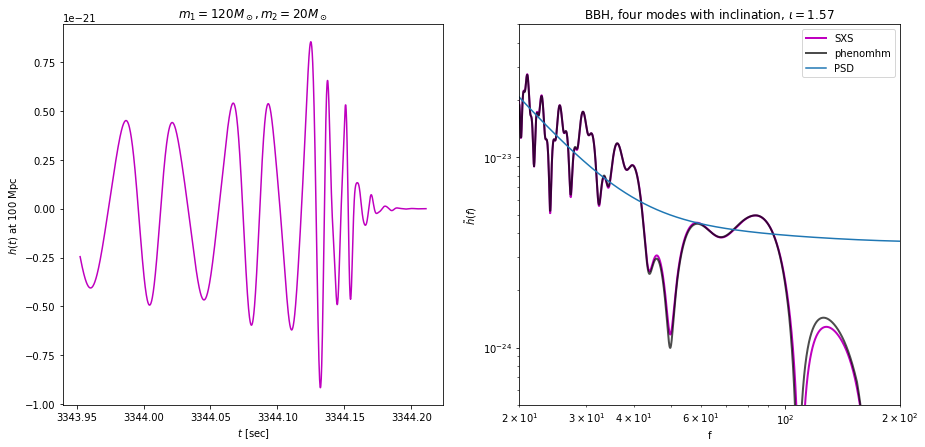

In [7]:
# This box compares the BBH SXS data which contains only four modes i.e. lm=21,22,33,44 against the phenom template 
# which always has only these four modes.

f_low = 20.
m1, m2 = 120.0, 20.0
M=m1+m2          # in MSUN
q=m1/m2
eta=m1*m2/M**2.

ra=0.
dec =0.
pol=0.00#,-1.57,-3.14
iota = 1.57

Fp,Fc = detector.overhead_antenna_pattern(ra, dec, pol)

cbc = 'BBH' #'NSBH'

data_dir = '/home/ajit.mehta/Ajit_work/phenom_hh/data/polarizations/four_modes'
out_dir = '/home/ajit.mehta/gr_consistency_highermodes/plots/four_modes'

start_time = time.time()

out_file = '%s_M_%.2f_iota_%.3f_pol_%.3f_t0_0'%(cbc, M, iota, pol)

print "... case:", cbc, iota, pol

# reading data
data_loc = data_dir + '/NRPolzns_%s_SpEC_q6.00_spin1[0.00,0.00,-0.00]_spin2[-0.00,-0.00,-0.00]_iota_%.2f_psi_%.2f.npz'%(cbc, iota, pol)
data = np.load(data_loc)
t_geom = data['t']
hp_geom = data['hp']
hc_geom = data['hc']
print "... read data"

r = 500. #in Mpc

# converting from geometric to SI units for distance r = 1 Mpc
# and computing the evolution of phase phi(t) and instantaneous frequency F(t) = (1/2*pi)*(dphi/dt)
t_SI = t_geom * (M*lal.MTSUN_SI)
hp_SI = hp_geom*(M*lal.MTSUN_SI)/(r*1e6*lal.PC_SI/lal.C_SI)
hc_SI = hc_geom*(M*lal.MTSUN_SI)/(r*1e6*lal.PC_SI/lal.C_SI)
h_SI = hp_SI + 1j*hc_SI
phi_SI = np.unwrap(np.angle(h_SI))
Foft_SI = np.gradient(phi_SI)/np.gradient(t_SI)/(2*np.pi)
dt_SI = t_SI[1] - t_SI[0]

# restricting waveform to lower number of samples.
idx_rstrctd = np.arange(len(t_SI)-100000,len(t_SI),1)
phi_SI_rstrctd, Foft_SI_rstrctd = phi_SI[idx_rstrctd], Foft_SI[idx_rstrctd]
t_SI_rstrctd, hp_SI_rstrctd, hc_SI_rstrctd = t_SI[idx_rstrctd], hp_SI[idx_rstrctd], hc_SI[idx_rstrctd]

N = len(hp_SI_rstrctd)

if int(2**np.ceil(np.log2(N))) > N:
                N1 = int(2**np.ceil(np.log2(N)))
print N,N1
# generate Fourier domain waveform
signal=Fp*hp_SI_rstrctd+Fc*hc_SI_rstrctd
signal_freq = np.fft.fft(taper_waveform(signal),N1)*dt_SI
data=signal_freq#+noise ## comment noise to generate noise free data

f_SI = np.fft.fftfreq(N1, d=dt_SI)
df = np.diff(f_SI)[0]
print '... df: %f'%df
psd = pycbc.psd.aLIGOZeroDetHighPower(len(f_SI), df, f_low)

m1=m1*MSUN_SI
m2=m2*MSUN_SI
mt=m1+m2
incl_angle = iota
phi=0.
lmax=4
Psi_ref=1.3
print m1/MSUN_SI, m2/MSUN_SI
hpf, hcf = phh.generate_phenomhmv1_fd(m1, m2, incl_angle, phi, f_low, df, int(N1/2.+1), lmax, [[2,2],[2,1],[3,3],[4,4]], Psi_ref)

hpf=hpf*mt*MRSUN_SI*MTSUN_SI*mt/(MSUN_SI*MSUN_SI*(1.0e6*r*PC_SI))
hcf=hcf*mt*MRSUN_SI*MTSUN_SI*mt/(MSUN_SI*MSUN_SI*(1.0e6*r*PC_SI))
best_fit_signal=Fp*hpf+Fc*hcf
NN = int(N1/2.+1)
f = np.linspace(0., df*(NN-1), NN)
data = data[0:NN]

kk = np.where(hp_SI_rstrctd == max(hp_SI_rstrctd))[0][0]
nn=1000

# plotting Fourier data and PSD
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(t_SI_rstrctd[kk-nn:kk+500],  hp_SI_rstrctd[kk-nn:kk+500],'m')
plt.xlabel('$t$ [sec]')
#plt.xlim(1671,1672.1)
plt.ylabel('$h(t)$ at 100 Mpc')
plt.title('$m_1 = 120 M_\odot, m_2 = 20 M_\odot$')
plt.subplot(122)
plt.loglog(f, abs(data),'m',lw=2, label='SXS')
plt.loglog(f, abs(best_fit_signal), 'k',lw=2,alpha=0.7,label='phenomhm')
plt.loglog(f_SI, np.sqrt(psd), label='PSD')
plt.xlim([f_low, 200.])
plt.ylim([5e-25, 5e-23])
plt.xlabel('f')
plt.ylabel('$\\tilde{h}(f)$')
plt.legend(loc='best')
plt.title('BBH, four modes with inclination, $\iota=%.2f$'%incl_angle)
plt.show()
        

... case: NSBH 1.57 0.0
... read data
100000 131072
... df: 0.044256

/home/sumitk/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



120.0 20.0
f_Nyq = 2900.407735
fM_band: 20.003728 Hz to 2900.363479 Hz
fM_band: 0.013794 Hz to 2.000000 Hz
......... using template mode l = 2 m  =  1
..printing f_ring = 0.06
......... generated taylorf2 phase in 0.046142 secs
f0 = 0.013794 ini_offset_phen_p = 80.460637
...... generated the phen ampl and phase in 0.115732 sec
..printing Psi_ref
1.3
......... using template mode l = 2 m  =  2
..printing f_ring = 0.07
......... generated taylorf2 phase in 0.047042 secs
f0 = 0.013794 ini_offset_phen_p = 112.716831
...... generated the phen ampl and phase in 0.131973 sec
..printing Psi_ref
1.3
......... using template mode l = 3 m  =  3
..printing f_ring = 0.11
......... generated taylorf2 phase in 0.066138 secs
f0 = 0.013794 ini_offset_phen_p = 119.635682
...... generated the phen ampl and phase in 0.190497 sec
..printing Psi_ref
1.3
......... using template mode l = 4 m  =  4
..printing f_ring = 0.15
......... generated taylorf2 phase in 0.064029 secs
f0 = 0.013794 ini_offset_phen_p = 

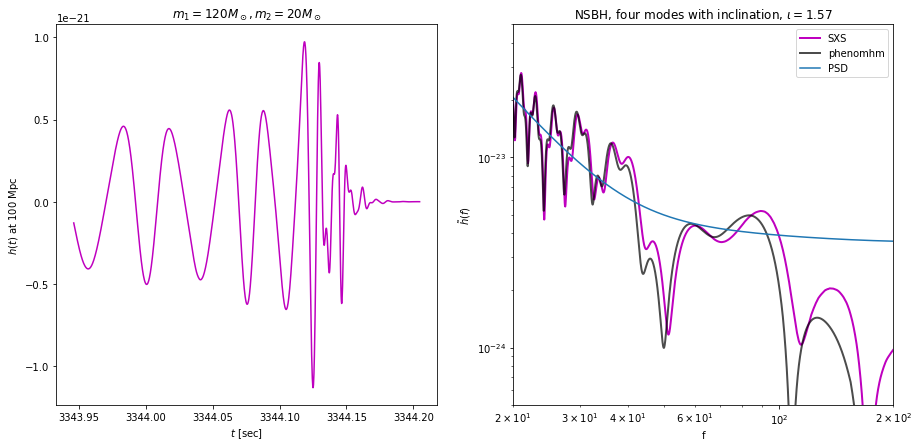

In [8]:
# This box compares the NSBH SXS data which contains only four modes i.e. lm=21,22,33,44 against 
# the phenom template  which always has only these four modes. Here we expect some mismatch and that is what 
# we need to capturethrough the modes consistency check.

f_low = 20.
m1, m2 = 120.0, 20.0
M=m1+m2          # in MSUN
q=m1/m2
eta=m1*m2/M**2.

ra=0.
dec =0.
pol=0.00#,-1.57,-3.14
iota = 1.57 ## this can be varied.

Fp,Fc = detector.overhead_antenna_pattern(ra, dec, pol)

cbc = 'NSBH'

data_dir = '/home/ajit.mehta/Ajit_work/phenom_hh/data/polarizations/four_modes'
out_dir = '/home/ajit.mehta/gr_consistency_highermodes/plots/four_modes'

start_time = time.time()

out_file = '%s_M_%.2f_iota_%.3f_pol_%.3f_t0_0'%(cbc, M, iota, pol)

print "... case:", cbc, iota, pol

# reading data
data_loc = data_dir + '/NRPolzns_%s_SpEC_q6.00_spin1[0.00,0.00,-0.00]_spin2[-0.00,-0.00,-0.00]_iota_%.2f_psi_%.2f.npz'%(cbc, iota, pol)
data = np.load(data_loc)
t_geom = data['t']
hp_geom = data['hp']
hc_geom = data['hc']
print "... read data"

r = 500. #in Mpc

# converting from geometric to SI units for distance r = 1 Mpc
# and computing the evolution of phase phi(t) and instantaneous frequency F(t) = (1/2*pi)*(dphi/dt)
t_SI = t_geom * (M*lal.MTSUN_SI)
hp_SI = hp_geom*(M*lal.MTSUN_SI)/(r*1e6*lal.PC_SI/lal.C_SI)
hc_SI = hc_geom*(M*lal.MTSUN_SI)/(r*1e6*lal.PC_SI/lal.C_SI)
h_SI = hp_SI + 1j*hc_SI
phi_SI = np.unwrap(np.angle(h_SI))
Foft_SI = np.gradient(phi_SI)/np.gradient(t_SI)/(2*np.pi)
dt_SI = t_SI[1] - t_SI[0]

# restricting waveform to lower number of samples.
idx_rstrctd = np.arange(len(t_SI)-100000,len(t_SI),1)
phi_SI_rstrctd, Foft_SI_rstrctd = phi_SI[idx_rstrctd], Foft_SI[idx_rstrctd]
t_SI_rstrctd, hp_SI_rstrctd, hc_SI_rstrctd = t_SI[idx_rstrctd], hp_SI[idx_rstrctd], hc_SI[idx_rstrctd]

N = len(hp_SI_rstrctd)

if int(2**np.ceil(np.log2(N))) > N:
                N1 = int(2**np.ceil(np.log2(N)))
print N,N1
# generate Fourier domain waveform
signal=Fp*hp_SI_rstrctd+Fc*hc_SI_rstrctd
signal_freq = np.fft.fft(taper_waveform(signal),N1)*dt_SI
data=signal_freq#+noise ## comment noise to generate noise free data

f_SI = np.fft.fftfreq(N1, d=dt_SI)
df = np.diff(f_SI)[0]
print '... df: %f'%df
psd = pycbc.psd.aLIGOZeroDetHighPower(len(f_SI), df, f_low)

m1=m1*MSUN_SI
m2=m2*MSUN_SI
mt=m1+m2
incl_angle = iota
phi=0.
lmax=4
Psi_ref=1.3
print m1/MSUN_SI, m2/MSUN_SI
hpf, hcf = phh.generate_phenomhmv1_fd(m1, m2, incl_angle, phi, f_low, df, int(N1/2.+1), lmax, [[2,2],[2,1],[3,3],[4,4]], Psi_ref)

hpf=hpf*mt*MRSUN_SI*MTSUN_SI*mt/(MSUN_SI*MSUN_SI*(1.0e6*r*PC_SI))
hcf=hcf*mt*MRSUN_SI*MTSUN_SI*mt/(MSUN_SI*MSUN_SI*(1.0e6*r*PC_SI))
best_fit_signal=Fp*hpf+Fc*hcf
NN = int(N1/2.+1)
f = np.linspace(0., df*(NN-1), NN)
data = data[0:NN]

kk = np.where(hp_SI_rstrctd == max(hp_SI_rstrctd))[0][0]
nn=1000

# plotting Fourier data and PSD
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(t_SI_rstrctd[kk-nn:kk+500],  hp_SI_rstrctd[kk-nn:kk+500],'m')
plt.xlabel('$t$ [sec]')
#plt.xlim(1671,1672.1)
plt.ylabel('$h(t)$ at 100 Mpc')
plt.title('$m_1 = 120 M_\odot, m_2 = 20 M_\odot$')
plt.subplot(122)
plt.loglog(f, abs(data),'m',lw=2, label='SXS')
plt.loglog(f, abs(best_fit_signal), 'k',lw=2,alpha=0.7,label='phenomhm')
plt.loglog(f_SI, np.sqrt(psd), label='PSD')
plt.xlim([f_low, 200.])
plt.ylim([5e-25, 5e-23])
plt.xlabel('f')
plt.ylabel('$\\tilde{h}(f)$')
plt.legend(loc='best')
plt.title('NSBH, four modes with inclination, $\iota=%.2f$'%incl_angle)
plt.show()
        

In [ ]:
# This box compares the BBH SXS data which contains all the modes up to l<=4 against the phenom template 
# containing just four equal (l=m) modes.

f_low = 20.
m1, m2 = 120.0, 20.0
M=m1+m2          # in MSUN
q=m1/m2
eta=m1*m2/M**2.

ra=0.
dec =0.
pol=0.00#,-1.57,-3.14
iota = 1.57

Fp,Fc = detector.overhead_antenna_pattern(ra, dec, pol)

cbc = 'BBH' #'NSBH'

data_dir = '/home/ajit.mehta/Ajit_work/phenom_hh/data/polarizations/all_modes'
out_dir = '/home/ajit.mehta/gr_consistency_highermodes/plots/all_modes'

start_time = time.time()

out_file = '%s_M_%.2f_iota_%.3f_pol_%.3f_t0_0'%(cbc, M, iota, pol)

print "... case:", cbc, iota, pol

# reading data
data_loc = data_dir + '/NRPolzns_%s_SpEC_q6.00_spin1[0.00,0.00,-0.00]_spin2[-0.00,-0.00,-0.00]_iota_%.2f_psi_%.2f.npz'%(cbc, iota, pol)
data = np.load(data_loc)
t_geom = data['t']
hp_geom = data['hp']
hc_geom = data['hc']
print "... read data"

r = 500. #in Mpc

# converting from geometric to SI units for distance r = 1 Mpc
# and computing the evolution of phase phi(t) and instantaneous frequency F(t) = (1/2*pi)*(dphi/dt)
t_SI = t_geom * (M*lal.MTSUN_SI)
hp_SI = hp_geom*(M*lal.MTSUN_SI)/(r*1e6*lal.PC_SI/lal.C_SI)
hc_SI = hc_geom*(M*lal.MTSUN_SI)/(r*1e6*lal.PC_SI/lal.C_SI)
h_SI = hp_SI + 1j*hc_SI
phi_SI = np.unwrap(np.angle(h_SI))
Foft_SI = np.gradient(phi_SI)/np.gradient(t_SI)/(2*np.pi)
dt_SI = t_SI[1] - t_SI[0]

# restricting waveform to lower number of samples.
idx_rstrctd = np.arange(len(t_SI)-100000,len(t_SI),1)
phi_SI_rstrctd, Foft_SI_rstrctd = phi_SI[idx_rstrctd], Foft_SI[idx_rstrctd]
t_SI_rstrctd, hp_SI_rstrctd, hc_SI_rstrctd = t_SI[idx_rstrctd], hp_SI[idx_rstrctd], hc_SI[idx_rstrctd]

N = len(hp_SI_rstrctd)

if int(2**np.ceil(np.log2(N))) > N:
                N1 = int(2**np.ceil(np.log2(N)))
print N,N1
# generate Fourier domain waveform
signal=Fp*hp_SI_rstrctd+Fc*hc_SI_rstrctd
signal_freq = np.fft.fft(taper_waveform(signal),N1)*dt_SI
data=signal_freq#+noise ## comment noise to generate noise free data

f_SI = np.fft.fftfreq(N1, d=dt_SI)
df = np.diff(f_SI)[0]
print '... df: %f'%df
psd = pycbc.psd.aLIGOZeroDetHighPower(len(f_SI), df, f_low)

m1=m1*MSUN_SI
m2=m2*MSUN_SI
mt=m1+m2
incl_angle = iota
phi=0.
lmax=4
Psi_ref=1.3
print m1/MSUN_SI, m2/MSUN_SI
hpf, hcf = phh.generate_phenomhmv1_fd(m1, m2, incl_angle, phi, f_low, df, int(N1/2.+1), lmax, [[2,2],[2,1],[3,3],[4,4]], Psi_ref)

hpf=hpf*mt*MRSUN_SI*MTSUN_SI*mt/(MSUN_SI*MSUN_SI*(1.0e6*r*PC_SI))
hcf=hcf*mt*MRSUN_SI*MTSUN_SI*mt/(MSUN_SI*MSUN_SI*(1.0e6*r*PC_SI))
best_fit_signal=Fp*hpf+Fc*hcf
NN = int(N1/2.+1)
f = np.linspace(0., df*(NN-1), NN)
data = data[0:NN]

kk = np.where(hp_SI_rstrctd == max(hp_SI_rstrctd))[0][0]
nn=1000

# plotting Fourier data and PSD
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(t_SI_rstrctd[kk-nn:kk+500],  hp_SI_rstrctd[kk-nn:kk+500],'m')
plt.xlabel('$t$ [sec]')
#plt.xlim(1671,1672.1)
plt.ylabel('$h(t)$ at 100 Mpc')
plt.title('$m_1 = 120 M_\odot, m_2 = 20 M_\odot$')
plt.subplot(122)
plt.loglog(f, abs(data),'m',lw=2, label='SXS')
plt.loglog(f, abs(best_fit_signal), 'k',lw=2,alpha=0.7,label='phenomhm')
plt.loglog(f_SI, np.sqrt(psd), label='PSD')
plt.xlim([f_low, 200.])
plt.ylim([5e-25, 5e-23])
plt.xlabel('f')
plt.ylabel('$\\tilde{h}(f)$')
plt.legend(loc='best')
plt.title('BBH, all modes with inclination, $\iota=%.2f$'%incl_angle)
plt.show()
        

... case: NSBH 1.57 0.0
... read data
100000 131072
... df: 0.044256

/home/sumitk/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



120.0 20.0
f_Nyq = 2900.407735
fM_band: 20.003728 Hz to 2900.363479 Hz
fM_band: 0.013794 Hz to 2.000000 Hz
......... using template mode l = 2 m  =  1
..printing f_ring = 0.06
......... generated taylorf2 phase in 0.067407 secs
f0 = 0.013794 ini_offset_phen_p = 80.460637
...... generated the phen ampl and phase in 0.197877 sec
..printing Psi_ref
1.3
......... using template mode l = 2 m  =  2
..printing f_ring = 0.07
......... generated taylorf2 phase in 0.062417 secs
f0 = 0.013794 ini_offset_phen_p = 112.716831
...... generated the phen ampl and phase in 0.175294 sec
..printing Psi_ref
1.3
......... using template mode l = 3 m  =  3
..printing f_ring = 0.11
......... generated taylorf2 phase in 0.066372 secs
f0 = 0.013794 ini_offset_phen_p = 119.635682
...... generated the phen ampl and phase in 0.190937 sec
..printing Psi_ref
1.3
......... using template mode l = 4 m  =  4
..printing f_ring = 0.15
......... generated taylorf2 phase in 0.064033 secs
f0 = 0.013794 ini_offset_phen_p = 

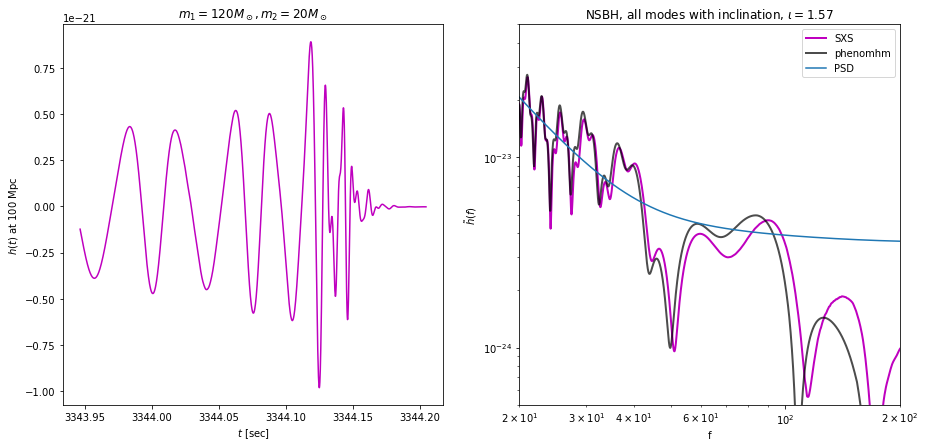

In [9]:
# This box compares the NSBH SXS data which contains all the modes up to l<=4 against 
# the phenom template.

f_low = 20.
m1, m2 = 120.0, 20.0
M=m1+m2          # in MSUN
q=m1/m2
eta=m1*m2/M**2.

ra=0.
dec =0.
pol=0.00#,-1.57,-3.14
iota = 1.57 ## this can be varied.

Fp,Fc = detector.overhead_antenna_pattern(ra, dec, pol)

cbc = 'NSBH'

data_dir = '/home/ajit.mehta/Ajit_work/phenom_hh/data/polarizations/all_modes'
out_dir = '/home/ajit.mehta/gr_consistency_highermodes/plots/all_modes'

start_time = time.time()

out_file = '%s_M_%.2f_iota_%.3f_pol_%.3f_t0_0'%(cbc, M, iota, pol)

print "... case:", cbc, iota, pol

# reading data
data_loc = data_dir + '/NRPolzns_%s_SpEC_q6.00_spin1[0.00,0.00,-0.00]_spin2[-0.00,-0.00,-0.00]_iota_%.2f_psi_%.2f.npz'%(cbc, iota, pol)
data = np.load(data_loc)
t_geom = data['t']
hp_geom = data['hp']
hc_geom = data['hc']
print "... read data"

r = 500. #in Mpc

# converting from geometric to SI units for distance r = 1 Mpc
# and computing the evolution of phase phi(t) and instantaneous frequency F(t) = (1/2*pi)*(dphi/dt)
t_SI = t_geom * (M*lal.MTSUN_SI)
hp_SI = hp_geom*(M*lal.MTSUN_SI)/(r*1e6*lal.PC_SI/lal.C_SI)
hc_SI = hc_geom*(M*lal.MTSUN_SI)/(r*1e6*lal.PC_SI/lal.C_SI)
h_SI = hp_SI + 1j*hc_SI
phi_SI = np.unwrap(np.angle(h_SI))
Foft_SI = np.gradient(phi_SI)/np.gradient(t_SI)/(2*np.pi)
dt_SI = t_SI[1] - t_SI[0]

# restricting waveform to lower number of samples.
idx_rstrctd = np.arange(len(t_SI)-100000,len(t_SI),1)
phi_SI_rstrctd, Foft_SI_rstrctd = phi_SI[idx_rstrctd], Foft_SI[idx_rstrctd]
t_SI_rstrctd, hp_SI_rstrctd, hc_SI_rstrctd = t_SI[idx_rstrctd], hp_SI[idx_rstrctd], hc_SI[idx_rstrctd]

N = len(hp_SI_rstrctd)

if int(2**np.ceil(np.log2(N))) > N:
                N1 = int(2**np.ceil(np.log2(N)))
print N,N1
# generate Fourier domain waveform
signal=Fp*hp_SI_rstrctd+Fc*hc_SI_rstrctd
signal_freq = np.fft.fft(taper_waveform(signal),N1)*dt_SI
data=signal_freq#+noise ## comment noise to generate noise free data

f_SI = np.fft.fftfreq(N1, d=dt_SI)
df = np.diff(f_SI)[0]
print '... df: %f'%df
psd = pycbc.psd.aLIGOZeroDetHighPower(len(f_SI), df, f_low)

m1=m1*MSUN_SI
m2=m2*MSUN_SI
mt=m1+m2
incl_angle = iota
phi=0.
lmax=4
Psi_ref=1.3
print m1/MSUN_SI, m2/MSUN_SI
hpf, hcf = phh.generate_phenomhmv1_fd(m1, m2, incl_angle, phi, f_low, df, int(N1/2.+1), lmax, [[2,2],[2,1],[3,3],[4,4]], Psi_ref)

hpf=hpf*mt*MRSUN_SI*MTSUN_SI*mt/(MSUN_SI*MSUN_SI*(1.0e6*r*PC_SI))
hcf=hcf*mt*MRSUN_SI*MTSUN_SI*mt/(MSUN_SI*MSUN_SI*(1.0e6*r*PC_SI))
best_fit_signal=Fp*hpf+Fc*hcf
NN = int(N1/2.+1)
f = np.linspace(0., df*(NN-1), NN)
data = data[0:NN]

kk = np.where(hp_SI_rstrctd == max(hp_SI_rstrctd))[0][0]
nn=1000

# plotting Fourier data and PSD
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(t_SI_rstrctd[kk-nn:kk+500],  hp_SI_rstrctd[kk-nn:kk+500],'m')
plt.xlabel('$t$ [sec]')
#plt.xlim(1671,1672.1)
plt.ylabel('$h(t)$ at 100 Mpc')
plt.title('$m_1 = 120 M_\odot, m_2 = 20 M_\odot$')
plt.subplot(122)
plt.loglog(f, abs(data),'m',lw=2, label='SXS')
plt.loglog(f, abs(best_fit_signal), 'k',lw=2,alpha=0.7,label='phenomhm')
plt.loglog(f_SI, np.sqrt(psd), label='PSD')
plt.xlim([f_low, 200.])
plt.ylim([5e-25, 5e-23])
plt.xlabel('f')
plt.ylabel('$\\tilde{h}(f)$')
plt.legend(loc='best')
plt.title('NSBH, all modes with inclination, $\iota=%.2f$'%incl_angle)
plt.show()
        